### 1. Install packages

In [1]:
!pip3 install --upgrade pip
!pip3 install tensorflow-estimator==2.1
!pip3 install tensorflow

  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.1.0 which is incompatible.
  Obtaining dependency information for tensorflow-estimator<2.14,>=2.13.0 from https://files.pythonhosted.org/packages/72/5c/c318268d96791c6222ad7df1651bbd1b2409139afeb6f468c0f327177016/tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Attempting uninst

In [2]:
!pip3 install torch torchvision torchaudio

### 2. Import libraries

In [1]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
import os
import pandas as pd

from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from tempfile import TemporaryDirectory

# img_width, img_height = 256, 256
img_width, img_height = 224, 224

2023-10-05 13:07:29.769827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def show_data(X, y):
    plt.imshow(X.permute(1, 2, 0))
    plt.title('y = '+str(y))


### Load/Split dataset and Create dataset loader

{'dishwasher-safe': 1, 'not-dishwasher-safe': 0}
[0 1]
{'train': 828, 'val': 409}


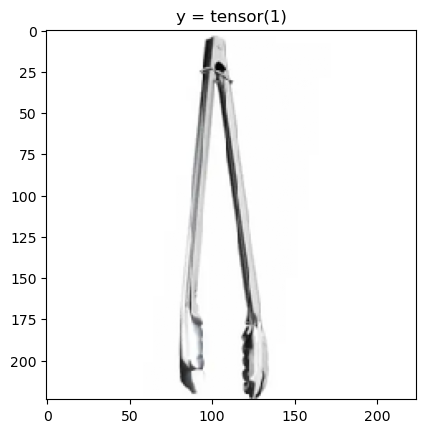

In [3]:
### Load data

positive_images_path = '/Users/anushree/Desktop/Dishwasher-safe Or Not/Data/final_data/dishwasher-safe'
negative_images_path = '/Users/anushree/Desktop/Dishwasher-safe Or Not/Data/final_data/not-dishwasher-safe'
ext = ['JPG', 'jpeg', 'png', 'jpg', 'gif', 'webp']
X = []
y = []
labels = {}


def load_data(images_path):
    counter = len(labels.keys())
    
    subdirs = [s for s in os.listdir(images_path) if os.path.isdir(os.path.join(images_path,s))]
    # print(subdirs)
    for subdir in subdirs:
        path = os.path.join(images_path,subdir)
        with os.scandir(path) as files:
            for filename in files:
                f = os.path.join(path, filename)
                # checking if it is a file
                if os.path.isfile(f) and f.split('.')[-1] in ext:
                    # load the image as a 224x224 array
                    img = load_img(f,target_size=(img_width, img_height))

                    X.append(transforms.ToTensor()(img))
                    
#                     label_name = images_path.split('/')[-1] + "-" +subdir
#                     encoded_label_name = counter
#                     if label_name in labels.keys():
#                         encoded_label_name = labels[label_name]
#                     else:
#                         labels[label_name] = counter
#                         counter = counter + 1
#                     y.append(encoded_label_name)
            
                    if images_path == positive_images_path:
                        labels['dishwasher-safe'] = 1
                        y.append(1)
                    else:
                        labels['not-dishwasher-safe'] = 0
                        y.append(0)   


load_data(positive_images_path)
load_data(negative_images_path)
print(labels)
print(np.unique(y))

### Split dataset for training and validation datasets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

### Create Pytorch Dataset Class object for training and validation dataset

class image_dataset(Dataset):
    def __init__(self,X,y, transform=None):
        self.x = X
        self.y = torch.tensor(y)

        self.len = len(X)
        self.transform = transform

    def __getitem__(self, index):
        sample = self.x[index],self.y[index]
        if self.transform:
            image = self.transform()
            sample = image,self.y[index]
        return sample

    def __len__(self):
        return self.len


train_dataset = image_dataset(X_train,y_train)
validation_dataset = image_dataset(X_val,y_val)

# Show the second image
show_data(train_dataset[0][0],train_dataset[0][1])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train':len(X_train),'val':len(X_val)}
print(dataset_sizes)

# Create a Data Loader for the training data 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50)
# Create a Data Loader for the validation data 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20)

### Generic method to train pre-built model

In [4]:
def train_prebuilt_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        acc_list = [] 
        loss_list = []
        

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_loader
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = validation_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        preds =  outputs.argmax(1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                acc_list.append(epoch_acc)
                loss_list.append(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, acc_list, loss_list

In [5]:
class_names = {v: k for k, v in labels.items()}
print(class_names)

{1: 'dishwasher-safe', 0: 'not-dishwasher-safe'}


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds =  outputs.argmax(1)
#             print(outputs)
#             print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                show_data(inputs.cpu().data[j],class_names[labels[j].item()])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
from scipy.interpolate import make_interp_spline

def plot_acc_loss(cost_list, accuracy_list):
    x = np.arange(start=0, stop=len(cost_list), step=1)
 
    X_cost_Spline = make_interp_spline(x, cost_list)
    X_acc_Spline = make_interp_spline(x, accuracy_list)

    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 200)
    
    cost_list_ = X_cost_Spline(X_)
    accuracy_list_ = X_acc_Spline(X_)

    # Plotting the Graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(X_,cost_list_, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot(X_, accuracy_list_, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

## ResNet18

In [8]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet18.fc.in_features

resnet18.fc = nn.Linear(num_ftrs, len(class_names.keys()))

resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.2)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
resnet18, acc_list, loss_list = train_prebuilt_model(resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)
torch.save(resnet18,'/Users/anushree/Desktop/Dishwasher-safe Or Not/Models/resnet18.pt')

Epoch 0/14
----------


KeyboardInterrupt: 

[0.6329191027632082, 0.5067578946902874, 0.39784390785267965, 0.41070218533641845, 0.2586368524293969, 0.376376317262941, 0.16256916188243506, 0.3427929316799915, 0.10105232214150221, 0.33550572761477937, 0.06544057653254069, 0.31889149716037407, 0.04507304583158758, 0.31378850827225846, 0.03512480926074556, 0.31650759273352136, 0.03318407703730939, 0.3165456540609339, 0.03186303279070175, 0.31591365399854693, 0.030802940256929628, 0.3156452323594711, 0.029874251431061163, 0.3155529363522611, 0.02903268556897911, 0.31549279746988873, 0.028246885449018166, 0.31548876329928566, 0.027530743106119873, 0.3154267616078148]


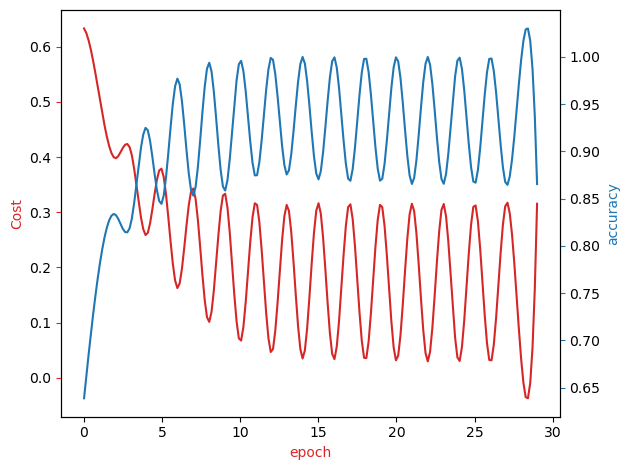

In [27]:
print(loss_list)
plot_acc_loss(loss_list, acc_list)


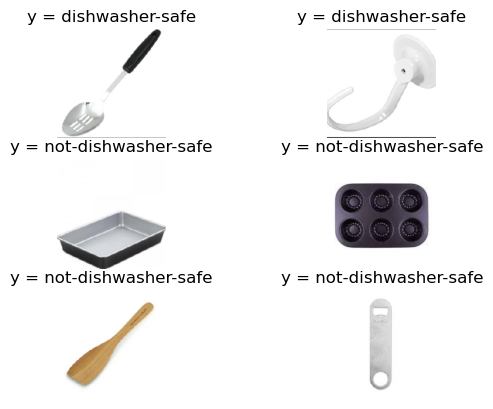

In [28]:
visualize_model(resnet18)


## ResNet50

Epoch 0/14
----------
train Loss: 0.6066 Acc: 0.6920
val Loss: 0.5282 Acc: 0.7090

Epoch 1/14
----------
train Loss: 0.2301 Acc: 0.9795
val Loss: 0.3341 Acc: 0.8435

Epoch 2/14
----------
train Loss: 0.0484 Acc: 0.9988
val Loss: 0.2742 Acc: 0.8949

Epoch 3/14
----------
train Loss: 0.0093 Acc: 1.0000
val Loss: 0.3188 Acc: 0.8826

Epoch 4/14
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.3121 Acc: 0.8875

Epoch 5/14
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3140 Acc: 0.8875

Epoch 6/14
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3231 Acc: 0.8924

Epoch 7/14
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3204 Acc: 0.8924

Epoch 8/14
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3208 Acc: 0.8924

Epoch 9/14
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3217 Acc: 0.8924

Epoch 10/14
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3227 Acc: 0.8924

Epoch 11/14
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3238 Acc: 0.8924

Ep

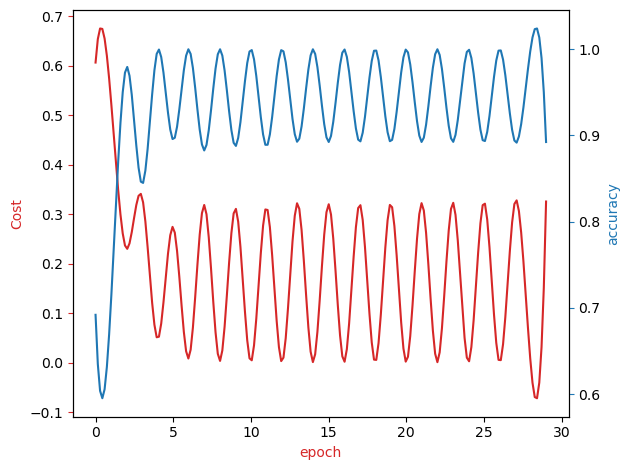

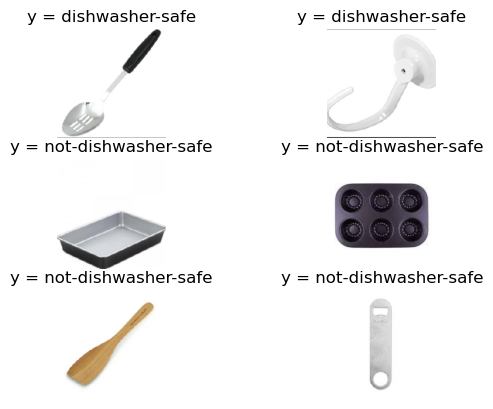

In [29]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Linear(num_ftrs,  len(class_names.keys()))
        
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(resnet50.parameters(), lr=1e-4)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet50, acc_list, loss_list = train_prebuilt_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)
plot_acc_loss(loss_list, acc_list)
torch.save(resnet50,'/Users/anushree/Desktop/Dishwasher-safe Or Not/Models/resnet50.pt')
visualize_model(resnet50)

In [30]:
acc_list, loss_list

([tensor(0.6920, dtype=torch.float64),
  tensor(0.7090, dtype=torch.float64),
  tensor(0.9795, dtype=torch.float64),
  tensor(0.8435, dtype=torch.float64),
  tensor(0.9988, dtype=torch.float64),
  tensor(0.8949, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8826, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8875, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8875, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(1., dtype=torch.f

### VGG16

In [31]:
vgg16 = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

vgg16.classifier[6] = nn.Linear(
            in_features=4096, out_features=len(class_names.keys()), bias=True
        )
        
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(vgg16.parameters(), lr=1e-4)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

vgg16,acc_list, loss_list = train_prebuilt_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

acc_list, loss_list

Epoch 0/14
----------
train Loss: 0.5160 Acc: 0.7379
val Loss: 0.5708 Acc: 0.7873

Epoch 1/14
----------
train Loss: 0.0981 Acc: 0.9626
val Loss: 0.3297 Acc: 0.8826

Epoch 2/14
----------
train Loss: 0.0369 Acc: 0.9879
val Loss: 0.3430 Acc: 0.8949

Epoch 3/14
----------
train Loss: 0.0258 Acc: 0.9940
val Loss: 0.3420 Acc: 0.9095

Epoch 4/14
----------
train Loss: 0.0143 Acc: 0.9988
val Loss: 0.4504 Acc: 0.8826

Epoch 5/14
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3412 Acc: 0.9267

Epoch 6/14
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3364 Acc: 0.9169

Epoch 7/14
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3348 Acc: 0.9193

Epoch 8/14
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3346 Acc: 0.9193

Epoch 9/14
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3342 Acc: 0.9193

Epoch 10/14
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3340 Acc: 0.9193

Epoch 11/14
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3342 Acc: 0.9218

Ep

([tensor(0.7379, dtype=torch.float64),
  tensor(0.7873, dtype=torch.float64),
  tensor(0.9626, dtype=torch.float64),
  tensor(0.8826, dtype=torch.float64),
  tensor(0.9879, dtype=torch.float64),
  tensor(0.8949, dtype=torch.float64),
  tensor(0.9940, dtype=torch.float64),
  tensor(0.9095, dtype=torch.float64),
  tensor(0.9988, dtype=torch.float64),
  tensor(0.8826, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9267, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9169, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9193, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9193, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9193, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9193, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9218, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9193, dtype=torch.float64),
  tensor(1., dtype

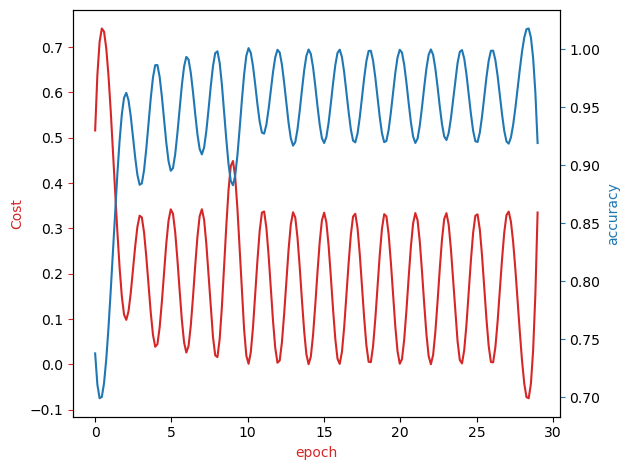

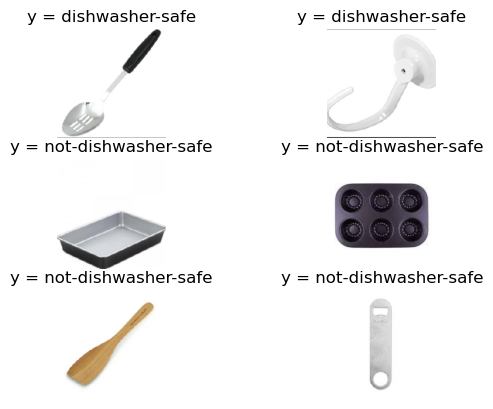

In [32]:
plot_acc_loss(loss_list, acc_list)
torch.save(vgg16,'/Users/anushree/Desktop/Dishwasher-safe Or Not/Models/vgg16.pt')
visualize_model(vgg16)

## AlexNet

In [33]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
num_ftrs = alexnet.classifier[-1].in_features

alexnet.classifier[-1] = nn.Linear(
            in_features=num_ftrs, out_features=len(class_names.keys()), bias=True
        )
        
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(alexnet.parameters(), lr=1e-4)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

alexnet, acc_list, loss_list = train_prebuilt_model(alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

acc_list, loss_list

Epoch 0/14
----------
train Loss: 0.6502 Acc: 0.6208
val Loss: 0.4886 Acc: 0.7824

Epoch 1/14
----------
train Loss: 0.3822 Acc: 0.8370
val Loss: 0.3792 Acc: 0.8313

Epoch 2/14
----------
train Loss: 0.2362 Acc: 0.9191
val Loss: 0.3672 Acc: 0.8533

Epoch 3/14
----------
train Loss: 0.1565 Acc: 0.9529
val Loss: 0.3072 Acc: 0.8631

Epoch 4/14
----------
train Loss: 0.0987 Acc: 0.9626
val Loss: 0.3539 Acc: 0.8435

Epoch 5/14
----------
train Loss: 0.0724 Acc: 0.9746
val Loss: 0.3343 Acc: 0.8704

Epoch 6/14
----------
train Loss: 0.0358 Acc: 0.9867
val Loss: 0.3837 Acc: 0.8680

Epoch 7/14
----------
train Loss: 0.0235 Acc: 0.9952
val Loss: 0.3107 Acc: 0.8924

Epoch 8/14
----------
train Loss: 0.0121 Acc: 0.9988
val Loss: 0.3171 Acc: 0.8802

Epoch 9/14
----------
train Loss: 0.0123 Acc: 0.9964
val Loss: 0.3094 Acc: 0.8778

Epoch 10/14
----------
train Loss: 0.0100 Acc: 0.9988
val Loss: 0.3126 Acc: 0.8826

Epoch 11/14
----------
train Loss: 0.0074 Acc: 1.0000
val Loss: 0.3139 Acc: 0.8851

Ep

([tensor(0.6208, dtype=torch.float64),
  tensor(0.7824, dtype=torch.float64),
  tensor(0.8370, dtype=torch.float64),
  tensor(0.8313, dtype=torch.float64),
  tensor(0.9191, dtype=torch.float64),
  tensor(0.8533, dtype=torch.float64),
  tensor(0.9529, dtype=torch.float64),
  tensor(0.8631, dtype=torch.float64),
  tensor(0.9626, dtype=torch.float64),
  tensor(0.8435, dtype=torch.float64),
  tensor(0.9746, dtype=torch.float64),
  tensor(0.8704, dtype=torch.float64),
  tensor(0.9867, dtype=torch.float64),
  tensor(0.8680, dtype=torch.float64),
  tensor(0.9952, dtype=torch.float64),
  tensor(0.8924, dtype=torch.float64),
  tensor(0.9988, dtype=torch.float64),
  tensor(0.8802, dtype=torch.float64),
  tensor(0.9964, dtype=torch.float64),
  tensor(0.8778, dtype=torch.float64),
  tensor(0.9988, dtype=torch.float64),
  tensor(0.8826, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8851, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.8900, dtype=torch.floa

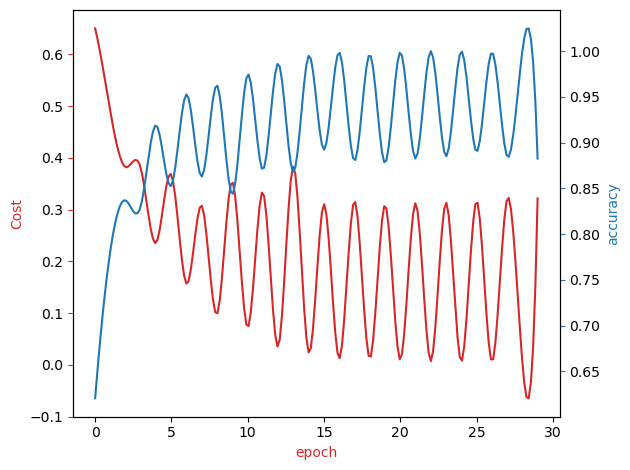

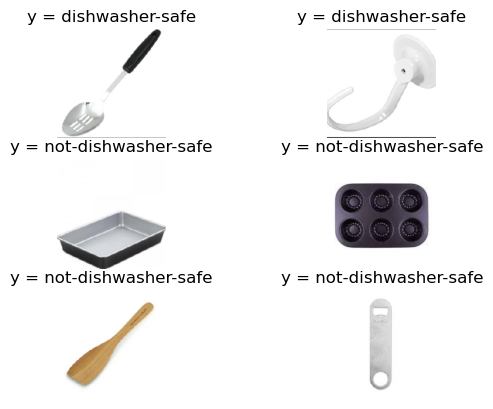

In [34]:
plot_acc_loss(loss_list, acc_list)
torch.save(alexnet,'/Users/anushree/Desktop/Dishwasher-safe Or Not/Models/alexnet.pt')
visualize_model(alexnet)